## 导入模块

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from transformers import AutoTokenizer, AutoModel
import os
import matplotlib.pyplot as plt



## 数据选取

### 读入数据

In [2]:


# 读取 TSV 文件
file_path = './data/brenda/enzyme_ogt.tsv'
ogt_df = pd.read_csv(file_path, sep='\t')

# 只保留 ogt_source 为 'experimental' 的样本
ogt_df = ogt_df[ogt_df['ogt_source'] == 'experimental']

# 查看过滤后的数据
print(ogt_df.head())
print(f"过滤后的样本总数: {ogt_df.shape[0]}")


        ec uniprot_id   domain               organism  ogt    ogt_source  \
0  1.1.1.1     Q8TZM9  Archaea    pyrococcus_furiosus   96  experimental   
1  1.1.1.1     H6Q9G7  Archaea  pyrobaculum_oguniense   90  experimental   
2  1.1.1.1     H6QDS7  Archaea  pyrobaculum_oguniense   90  experimental   
3  1.1.1.1     H6Q7F2  Archaea  pyrobaculum_oguniense   90  experimental   
4  1.1.1.1     H6QB36  Archaea  pyrobaculum_oguniense   90  experimental   

   topt topt_source  
0    77   predicted  
1    69   predicted  
2    73   predicted  
3    70   predicted  
4    72   predicted  
过滤后的样本总数: 5597122


In [3]:
# 获取 ogt 的最小值和最大值
min_ogt = ogt_df['ogt'].min()
max_ogt = ogt_df['ogt'].max()

# 打印 ogt 范围
print(f"ogt 范围从 {min_ogt} 到 {max_ogt}")

# 使用 pd.cut 将 ogt 按照每 5 度划分区间
ogt_bins = range(min_ogt // 5 * 5, max_ogt + 5, 5)  # 设定每 5 度一个区间
ogt_df['ogt_range'] = pd.cut(ogt_df['ogt'], bins=ogt_bins, right=False)

# 统计每个区间内的样本数量
ogt_range_counts = ogt_df['ogt_range'].value_counts().sort_index()

# 打印每个区间的统计结果
print("\n每 5 度区间的样本数量：")
print(ogt_range_counts)

ogt 范围从 4 到 103

每 5 度区间的样本数量：
[0, 5)           2453
[5, 10)          5935
[10, 15)        12712
[15, 20)        34727
[20, 25)       251903
[25, 30)      1694358
[30, 35)      1324797
[35, 40)      2076840
[40, 45)        18745
[45, 50)        21583
[50, 55)        22593
[55, 60)        41643
[60, 65)        26262
[65, 70)        18468
[70, 75)        18638
[75, 80)         5379
[80, 85)         6660
[85, 90)         7558
[90, 95)         2822
[95, 100)        2597
[100, 105)        449
Name: ogt_range, dtype: int64


In [ ]:


# 创建一个新的 DataFrame 来存放最终筛选后的数据
filtered_ogt_df = pd.DataFrame()

# 遍历每个 5 度区间
for ogt_range in ogt_df['ogt_range'].unique():
    # 获取当前区间的数据
    range_df = ogt_df[ogt_df['ogt_range'] == ogt_range]
    
    # 如果该区间的样本数小于等于 2000，则直接保留所有样本
    if len(range_df) <= 5000:
        filtered_ogt_df = pd.concat([filtered_ogt_df, range_df])
    else:
        # 对当前区间的样本进行随机抽样，抽取 2000 个样本
        sampled_df = range_df.sample(5000, random_state=42)
        filtered_ogt_df = pd.concat([filtered_ogt_df, sampled_df])

# 打印最终筛选后的 DataFrame
print(filtered_ogt_df.head())
print(f"过滤后的样本总数: {filtered_ogt_df.shape[0]}")


              ec uniprot_id   domain               organism  ogt  \
0        1.1.1.1     Q8TZM9  Archaea    pyrococcus_furiosus   96   
5558   1.1.1.100     I6U632  Archaea    pyrococcus_furiosus   96   
21449  1.1.1.103     Q8U259  Archaea    pyrococcus_furiosus   96   
21450  1.1.1.103     I6UPN6  Archaea    pyrococcus_furiosus   96   
21451  1.1.1.103     O58389  Archaea  pyrococcus_horikoshii   95   

         ogt_source  topt topt_source  ogt_range  
0      experimental    77   predicted  [95, 100)  
5558   experimental    73   predicted  [95, 100)  
21449  experimental    71   predicted  [95, 100)  
21450  experimental    71   predicted  [95, 100)  
21451  experimental    74   predicted  [95, 100)  
过滤后的样本总数: 93321


In [5]:
# 打印最终筛选后的 DataFrame
print(filtered_ogt_df.head())
print(f"过滤后的样本总数: {filtered_ogt_df.shape[0]}")

# 打印筛选后每一度的个数
ogt_counts_after_filtering = filtered_ogt_df['ogt'].value_counts().sort_index()
print("\n筛选后每一度的样本个数：")
print(ogt_counts_after_filtering)


              ec uniprot_id   domain               organism  ogt  \
0        1.1.1.1     Q8TZM9  Archaea    pyrococcus_furiosus   96   
5558   1.1.1.100     I6U632  Archaea    pyrococcus_furiosus   96   
21449  1.1.1.103     Q8U259  Archaea    pyrococcus_furiosus   96   
21450  1.1.1.103     I6UPN6  Archaea    pyrococcus_furiosus   96   
21451  1.1.1.103     O58389  Archaea  pyrococcus_horikoshii   95   

         ogt_source  topt topt_source  ogt_range  
0      experimental    77   predicted  [95, 100)  
5558   experimental    73   predicted  [95, 100)  
21449  experimental    71   predicted  [95, 100)  
21450  experimental    71   predicted  [95, 100)  
21451  experimental    74   predicted  [95, 100)  
过滤后的样本总数: 93321

筛选后每一度的样本个数：
4      2453
5      1108
7       649
8       683
9      2560
       ... 
98      508
99      209
100     224
102       1
103     224
Name: ogt, Length: 90, dtype: int64


In [6]:
# 如果你需要完整输出，可以直接打印出
print("\n完整的筛选后每一度的样本个数：")
for degree, count in ogt_counts_after_filtering.items():
    print(f"{degree}: {count}")


完整的筛选后每一度的样本个数：
4: 2453
5: 1108
7: 649
8: 683
9: 2560
10: 1901
11: 530
12: 800
13: 856
14: 913
15: 1280
16: 494
17: 456
18: 569
19: 2201
20: 1278
21: 388
22: 624
23: 635
24: 2075
25: 509
26: 509
27: 758
28: 1930
29: 1294
30: 2962
31: 501
32: 389
33: 382
34: 766
35: 626
36: 970
37: 3377
38: 21
39: 6
40: 1594
41: 965
42: 1814
43: 270
44: 357
45: 3156
46: 726
47: 648
48: 304
49: 166
50: 2818
51: 533
52: 364
53: 489
54: 796
55: 2892
56: 354
57: 918
58: 783
59: 53
60: 4114
61: 1
62: 451
63: 283
64: 151
65: 2577
66: 286
67: 338
68: 1047
69: 752
70: 3063
71: 1054
72: 55
73: 335
74: 493
75: 4650
79: 350
80: 3069
81: 1681
82: 30
83: 219
84: 1
85: 3696
87: 570
88: 734
90: 2561
92: 261
95: 986
96: 702
97: 192
98: 508
99: 209
100: 224
102: 1
103: 224


In [7]:
# 将filtered_ogt_df保存为csv文件
filtered_ogt_df.to_csv('./data/brenda/filtered_ogt_with_uniprot.csv', index=False)

In [8]:
print(filtered_ogt_df['uniprot_id'].head())


0        Q8TZM9
5558     I6U632
21449    Q8U259
21450    I6UPN6
21451    O58389
Name: uniprot_id, dtype: object


##  读取含序列文件

In [ ]:

# 读取 CSV 文件
file_path = './data/brenda/filtered_ogt_with_sequences.csv'
ogt_df = pd.read_csv(file_path)

# 查看过滤后的数据
print(ogt_df.head())
print(f"过滤后的样本总数: {ogt_df.shape[0]}")


          ec uniprot_id   domain               organism  ogt    ogt_source  \
0    1.1.1.1     Q8TZM9  Archaea    pyrococcus_furiosus   96  experimental   
1  1.1.1.100     I6U632  Archaea    pyrococcus_furiosus   96  experimental   
2  1.1.1.103     Q8U259  Archaea    pyrococcus_furiosus   96  experimental   
3  1.1.1.103     I6UPN6  Archaea    pyrococcus_furiosus   96  experimental   
4  1.1.1.103     O58389  Archaea  pyrococcus_horikoshii   95  experimental   

   topt topt_source  ogt_range  \
0    77   predicted  [95, 100)   
1    73   predicted  [95, 100)   
2    71   predicted  [95, 100)   
3    71   predicted  [95, 100)   
4    74   predicted  [95, 100)   

                                    protein_sequence  
0  MKRVNAFNDLKRIGDDKVTAIGMGTWGIGGRETPDYSRDKESIEAI...  
1  MPCYNLKNKVAIVTGGGQGIGAAIAQLFAENGAKVVLAEIDEEAGL...  
2  MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...  
3  MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...  
4  MSEKMVAIMKTKPGYGAELVEVDVPKPGPGEVLIKVLATSICGTDL..

In [10]:
# 过滤掉X和y中有缺失值的行
ogt_df_clean = ogt_df.dropna(subset=['uniprot_id', 'ogt', 'ogt_range', 'protein_sequence'])
# 筛选出 protein_sequence 长度大于 50 的行
ogt_df_filtered = ogt_df_clean[ogt_df_clean['protein_sequence'].apply(len) > 50]
print(f"过滤后的样本总数: {ogt_df_filtered.shape[0]}")
display(ogt_df_filtered)

过滤后的样本总数: 93220


,ec,uniprot_id,domain,organism,ogt,ogt_source,topt,topt_source,ogt_range,protein_sequence
0,1.1.1.1,Q8TZM9,Archaea,pyrococcus_furiosus,96,experimental,77,predicted,"[95, 100)",MKRVNAFNDLKRIGDDKVTAIGMGTWGIGGRETPDYSRDKESIEAI...
1,1.1.1.100,I6U632,Archaea,pyrococcus_furiosus,96,experimental,73,predicted,"[95, 100)",MPCYNLKNKVAIVTGGGQGIGAAIAQLFAENGAKVVLAEIDEEAGL...
2,1.1.1.103,Q8U259,Archaea,pyrococcus_furiosus,96,experimental,71,predicted,"[95, 100)",MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...
3,1.1.1.103,I6UPN6,Archaea,pyrococcus_furiosus,96,experimental,71,predicted,"[95, 100)",MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...
4,1.1.1.103,O58389,Archaea,pyrococcus_horikoshii,95,experimental,74,predicted,"[95, 100)",MSEKMVAIMKTKPGYGAELVEVDVPKPGPGEVLIKVLATSICGTDL...
...,...,...,...,...,...,...,...,...,...,...
93316,6.4.1.2,A0A127B8Y0,Archaea,pyrococcus_kukulkanii,100,experimental,77,predicted,"[100, 105)",MKVRVVINGEEYEVEVEEVMPGKFRVTLSGETYEVEAKDLGISVPV...
93317,6.5.1.1,G0EDM6,Archaea,pyrolobus_fumarii,103,experimental,71,predicted,"[100, 105)",MPMPFSILAETFEKLERTTSRTQMVLYLVDLFKKTPPETIDKVVYF...
93318,6.5.1.1,A0A127BCM3,Archaea,pyrococcus_kukulkanii,100,experimental,70,predicted,"[100, 105)",MRYLELAQLYQKLEKTTMKLIKTRLVADFLKKVPDDHLEFIPYLIL...
93319,6.5.1.4,G0EEW5,Archaea,pyrolobus_fumarii,103,experimental,72,predicted,"[100, 105)",MREVVIDGSMGEGGGQILRTSVALAAVLGIKLRVYNIRAKRKNPGL...


In [11]:
# 输出筛选后的 DataFrame 到一个新的 CSV 文件
output_file_path = './data/brenda/filtered_ogt_with_sequences_filtered.csv'
ogt_df_filtered.to_csv(output_file_path, index=False)

In [12]:
# 更新X和y，确保它们没有缺失值
X = ogt_df_filtered['protein_sequence']
y = ogt_df_filtered['ogt']

In [13]:
display(X)

0        MKRVNAFNDLKRIGDDKVTAIGMGTWGIGGRETPDYSRDKESIEAI...
1        MPCYNLKNKVAIVTGGGQGIGAAIAQLFAENGAKVVLAEIDEEAGL...
2        MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...
3        MSEKMVAIMKTKPEYGAELVEVDVPKPGPGEVLIKILATSICGTDL...
4        MSEKMVAIMKTKPGYGAELVEVDVPKPGPGEVLIKVLATSICGTDL...
                               ...                        
93316    MKVRVVINGEEYEVEVEEVMPGKFRVTLSGETYEVEAKDLGISVPV...
93317    MPMPFSILAETFEKLERTTSRTQMVLYLVDLFKKTPPETIDKVVYF...
93318    MRYLELAQLYQKLEKTTMKLIKTRLVADFLKKVPDDHLEFIPYLIL...
93319    MREVVIDGSMGEGGGQILRTSVALAAVLGIKLRVYNIRAKRKNPGL...
93320    MIIIDGSYGEGGGQILRTSIALSAITEEPVKIINIRANRPNPGLRP...
Name: protein_sequence, Length: 93220, dtype: object

## 加载esm2

In [14]:


# 检查模型文件夹中的文件
model_path = './esm2'
files_in_directory = os.listdir(model_path)
print(files_in_directory)


['config.json', 'tokenizer_config.json', 'tf_model.h5', 'vocab.txt', 'README.md', 'gitattributes', 'model.safetensors', 'special_tokens_map.json', 'pytorch_model.bin']


In [ ]:

# 加载模型
model_path = './esm2'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# 示例蛋白质序列
sequence = "MKRVNAFNDLKRIGDDKVTAIGMGTWGIGGRETPDYSRDKESIEAI"
tokens = tokenizer(sequence, return_tensors='pt')
embedding = model(**tokens)

print("Protein sequence embedding:", embedding.last_hidden_state)


2025-01-09 18:49:53.291486: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 18:49:53.411112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 18:49:54.313193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of EsmModel were not initialized from the model checkpoint at ./esm2 and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Protein sequence embedding: tensor([[[ 0.0551, -0.0236,  0.0425,  ..., -0.2069,  0.1609, -0.0647],
         [ 0.0273,  0.0158, -0.0223,  ...,  0.0957, -0.1379, -0.0370],
         [ 0.0748,  0.0551, -0.1801,  ..., -0.1646, -0.0230, -0.1027],
         ...,
         [-0.1598,  0.0686, -0.0888,  ..., -0.1465,  0.0375, -0.1079],
         [ 0.0394,  0.1687, -0.0300,  ..., -0.0932,  0.0410,  0.0678],
         [ 0.0446, -0.0575, -0.0235,  ..., -0.2536,  0.1520, -0.0430]]],
       grad_fn=<NativeLayerNormBackward0>)


In [19]:

# 检查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载本地 ESM 模型和分词器
model_path = './esm2'  # 替换为您的本地模型路径
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# 将模型移动到 GPU
model = model.to(device)
model.eval()  # 设置为评估模式

# 示例蛋白质序列
sequence = "MKRVNAFNDLKRIGDDKVTAIGMGTWGIGGRETPDYSRDKESIEAI"

# 对序列进行分词
tokens = tokenizer(sequence, return_tensors='pt')

# 将输入数据移动到 GPU
tokens = {key: value.to(device) for key, value in tokens.items()}

# 前向传播以计算嵌入
with torch.no_grad():
    embedding = model(**tokens)

# 获取最后一层的隐藏状态作为嵌入
embedding_tensor = embedding.last_hidden_state

# 打印嵌入的维度和前几项值
print("Embedding shape:", embedding_tensor.shape)
print("First token embedding:", embedding_tensor[0, 0, :5].cpu().numpy())


Some weights of EsmModel were not initialized from the model checkpoint at ./esm2 and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Embedding shape: torch.Size([1, 48, 1280])
First token embedding: [ 0.05507119 -0.02361331  0.04248878  0.04023326 -0.11215127]


In [17]:
# 将目标值转换为 PyTorch 张量
y = torch.tensor(y.values, dtype=torch.float32)

In [2]:

# 加载嵌入
embedding_file = '/mnt/data/lzp/OGT/output/protein_embeddings.pt'

# 安全加载嵌入
X_embeddings = torch.load(embedding_file, weights_only=True)

# 检查数据类型
if isinstance(X_embeddings, list):
    # 确保每个元素是张量
    X_embeddings = [torch.tensor(embed) for embed in X_embeddings]
    # 使用 torch.cat 将嵌入合并为一个张量
    X = torch.cat(X_embeddings, dim=0).numpy()
else:
    # 如果已经是张量，则直接使用
    X = X_embeddings.numpy()

print(f"嵌入维度: {X.shape}")


嵌入维度: (93220, 1280)


## 加载输入

In [3]:

# 加载嵌入
embedding_file = '/mnt/data/lzp/OGT/output/protein_embeddings.pt'
X_embeddings = torch.load(embedding_file)

# 将嵌入数据转换为 NumPy 数组
if isinstance(X_embeddings, list):
    X_embeddings = [torch.tensor(embed) for embed in X_embeddings]
    X = torch.cat(X_embeddings, dim=0).numpy()
else:
    X = X_embeddings.numpy()

# 加载标签
labels_file = '/mnt/data/lzp/OGT/output/protein_labels.csv'
y = pd.read_csv(labels_file)['ogt'].values

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipykernel_74364/2614336385.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_embeddings = torch.load(embedding_file)


In [6]:
display(X_train)

array([[ 0.13860454, -0.01982333,  0.06760556, ..., -0.2194842 ,
         0.1402502 , -0.03294966],
       [ 0.04748615, -0.04672382,  0.10916156, ..., -0.2658054 ,
         0.12755555,  0.03218624],
       [ 0.07756352, -0.00651531,  0.09605274, ..., -0.16026232,
         0.0653003 , -0.05712902],
       ...,
       [ 0.05038873, -0.04796024,  0.09093667, ..., -0.2415549 ,
         0.12138613,  0.02281654],
       [ 0.09187121, -0.02857499,  0.08137584, ..., -0.27318165,
         0.13799365, -0.09697802],
       [ 0.05936187, -0.01508765,  0.11825316, ..., -0.17775728,
         0.13404396, -0.03210917]], dtype=float32)

In [3]:

# 统计 y 每 5 度的分布
bins = np.arange(min(y), max(y) + 5, 5)  # 定义每 5 度的分割点
y_binned = pd.cut(y, bins=bins, right=False)  # 分组，左闭右开区间
distribution = y_binned.value_counts().sort_index()  # 统计每组样本数量
print("y 每 5 度的分布情况：")
print(distribution)

# 分层分割数据，确保分布平衡
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned
)

# 检查分割后训练集和测试集的分布
train_distribution = pd.cut(y_train, bins=bins, right=False).value_counts().sort_index()
test_distribution = pd.cut(y_test, bins=bins, right=False).value_counts().sort_index()

print("\n训练集 y 的分布：")
print(train_distribution)
print("\n测试集 y 的分布：")
print(test_distribution)

y 每 5 度的分布情况：
[4, 9)       4881
[9, 14)      6647
[14, 19)     3711
[19, 24)     5113
[24, 29)     5778
[29, 34)     5525
[34, 39)     5747
[39, 44)     4644
[44, 49)     5189
[49, 54)     4366
[54, 59)     5736
[59, 64)     4899
[64, 69)     4399
[69, 74)     5255
[74, 79)     5137
[79, 84)     5341
[84, 89)     4994
[89, 94)     2821
[94, 99)     2380
[99, 104)     657
dtype: int64

训练集 y 的分布：
[4, 9)       3905
[9, 14)      5317
[14, 19)     2969
[19, 24)     4090
[24, 29)     4622
[29, 34)     4420
[34, 39)     4598
[39, 44)     3715
[44, 49)     4151
[49, 54)     3493
[54, 59)     4589
[59, 64)     3919
[64, 69)     3519
[69, 74)     4204
[74, 79)     4110
[79, 84)     4273
[84, 89)     3995
[89, 94)     2257
[94, 99)     1904
[99, 104)     526
dtype: int64

测试集 y 的分布：
[4, 9)        976
[9, 14)      1330
[14, 19)      742
[19, 24)     1023
[24, 29)     1156
[29, 34)     1105
[34, 39)     1149
[39, 44)      929
[44, 49)     1038
[49, 54)      873
[54, 59)     1147
[59, 64)      980


### 随机森林


随机森林回归模型评价指标：
均方误差 (MSE): 119.50
决定系数 (R²): 0.83


/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38543 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26862 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/pyth

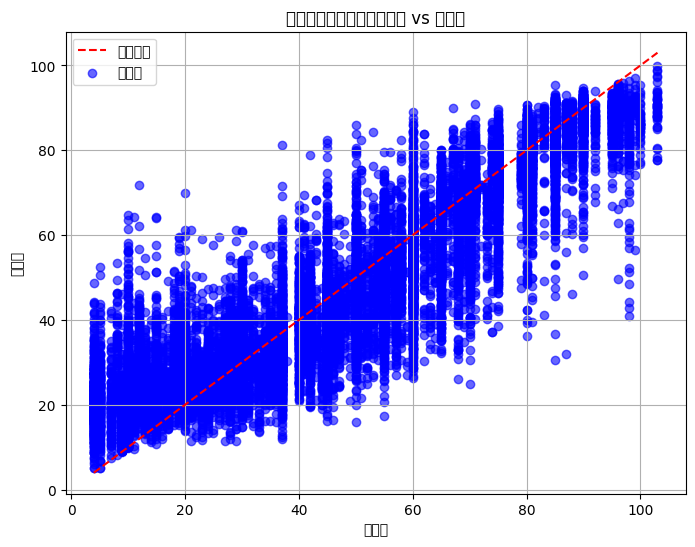

In [5]:


# 初始化随机森林回归模型
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练随机森林回归模型
regressor.fit(X_train, y_train)

# 使用测试集进行预测
y_pred = regressor.predict(X_test)

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 输出评价指标
print("\n随机森林回归模型评价指标：")
print(f"均方误差 (MSE): {mse:.2f}")
print(f"决定系数 (R²): {r2:.2f}")

# 可视化实际值与预测值的对比
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='预测值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='理想预测')
plt.xlabel("实际值")
plt.ylabel("预测值")
plt.title("随机森林回归模型：实际值 vs 预测值")
plt.legend()
plt.grid(True)
plt.show()


### XGBoost

/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [00:21:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [00:21:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [00:21:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotl


XGBoost回归模型评价指标：
均方误差 (MSE): 124.34
决定系数 (R²): 0.82


/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 24402 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22411 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site

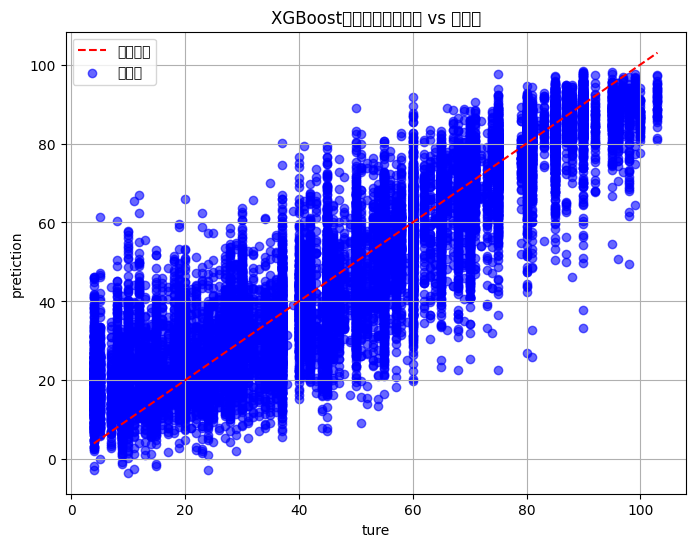

模型已保存至 'xgboost_model.pkl'


In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# 配置 XGBoost 使用 GPU
xgb_regressor = xgb.XGBRegressor(
    tree_method='gpu_hist',  # 使用 GPU 加速的 hist 方法
    device='cuda',           # 使用 GPU
    random_state=42
)

# 训练模型
xgb_regressor.fit(X_train, y_train)

# 使用模型进行预测
y_pred = xgb_regressor.predict(X_test)

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nXGBoost回归模型评价指标：")
print(f"均方误差 (MSE): {mse:.2f}")
print(f"决定系数 (R²): {r2:.2f}")

# 可视化实际值与预测值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='预测值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='理想预测')
plt.xlabel("ture")
plt.ylabel("pretiction")
plt.title("XGBoost回归模型：实际值 vs 预测值")
plt.legend()
plt.grid(True)
plt.show()

# 保存模型
joblib.dump(xgb_regressor, 'xgboost_model.pkl')  # 保存模型

print("模型已保存至 'xgboost_model.pkl'")


In [5]:
# 保存模型
joblib.dump(best_model, 'xgboost_best_model_fa.pkl')  # 保存最佳模型

print("模型已保存至 'xgboost_best_model_fa.pkl'")

模型已保存至 'xgboost_best_model_fa.pkl'


### 神经网络

Epoch [10/100], Loss: 134.1535
Epoch [20/100], Loss: 124.7072
Epoch [30/100], Loss: 113.5946
Epoch [40/100], Loss: 108.0321
Epoch [50/100], Loss: 100.7346
Epoch [60/100], Loss: 96.4951
Epoch [70/100], Loss: 91.0030
Epoch [80/100], Loss: 87.3422
Epoch [90/100], Loss: 83.8490
Epoch [100/100], Loss: 80.1776

深度学习回归模型评价指标：
均方误差 (MSE): 103.06
决定系数 (R²): 0.85


/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/pyth

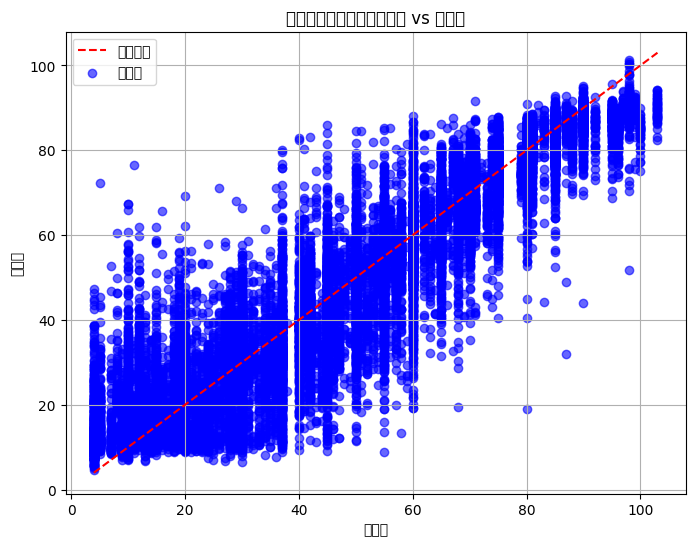

In [6]:

# 定义一个简单的深度神经网络 (DNN) 模型
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)  # 输出为一个标量，回归任务
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 将训练数据转为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 回归任务，输出为一维
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建 DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 初始化模型
input_dim = X_train.shape[1]  # 特征维度
model = DNNModel(input_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 测试模型
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# 将预测结果转换为 numpy 数组
y_pred = y_pred_tensor.numpy()

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 输出评价指标
print("\n深度学习回归模型评价指标：")
print(f"均方误差 (MSE): {mse:.2f}")
print(f"决定系数 (R²): {r2:.2f}")

# 可视化实际值与预测值的对比
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='预测值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='理想预测')
plt.xlabel("实际值")
plt.ylabel("预测值")
plt.title("深度学习回归模型：实际值 vs 预测值")
plt.legend()
plt.grid(True)
plt.show()


Epoch [10/200], Loss: 113.8925
Epoch [20/200], Loss: 104.9587
Epoch [30/200], Loss: 100.2515
Epoch [40/200], Loss: 96.7597
Epoch [50/200], Loss: 96.0515
Epoch [60/200], Loss: 94.4275
Epoch [70/200], Loss: 94.0408
Epoch [80/200], Loss: 93.5083
Epoch [90/200], Loss: 92.5521
Epoch [100/200], Loss: 91.9292
Epoch [110/200], Loss: 91.3560
Epoch [120/200], Loss: 90.4738
Epoch [130/200], Loss: 90.7190
Epoch [140/200], Loss: 89.9501
Epoch [150/200], Loss: 89.3133
Epoch [160/200], Loss: 89.7664
Epoch [170/200], Loss: 89.5218
Epoch [180/200], Loss: 89.8070
Epoch [190/200], Loss: 88.8394
Epoch [200/200], Loss: 87.4960

深度学习回归模型评价指标：
均方误差 (MSE): 98.27
决定系数 (R²): 0.86


/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lzp/miniconda3/envs/myenv/lib/pyth

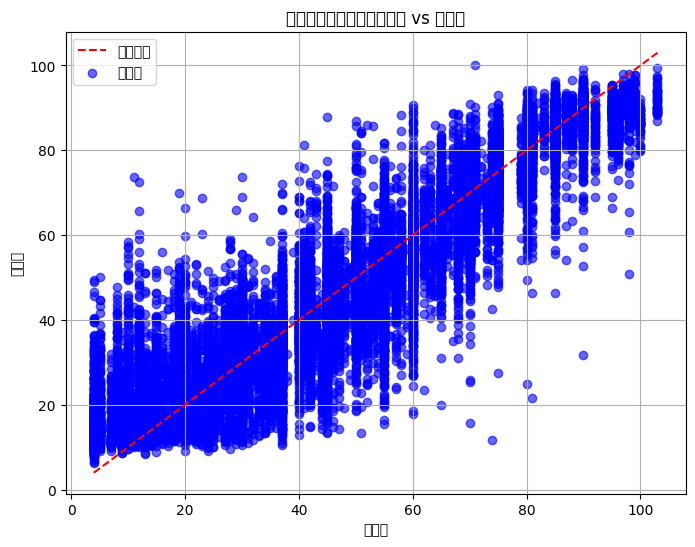

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 定义一个更深的深度神经网络 (DNN) 模型
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)  # 添加 Batch Normalization
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 1)  # 输出为一个标量，回归任务
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 增加 Dropout 比例
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # 加入 Batch Normalization
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))  # 加入 Batch Normalization
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))  # 加入 Batch Normalization
        x = self.fc4(x)
        return x

# 将训练数据转为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 回归任务，输出为一维
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建 DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # 调整批量大小
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 初始化模型
input_dim = X_train.shape[1]  # 特征维度
model = DNNModel(input_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # 加入 L2 正则化

# 训练模型
epochs = 200  # 增加训练轮数
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 测试模型
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# 将预测结果转换为 numpy 数组
y_pred = y_pred_tensor.numpy()

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 输出评价指标
print("\n深度学习回归模型评价指标：")
print(f"均方误差 (MSE): {mse:.2f}")
print(f"决定系数 (R²): {r2:.2f}")

# 可视化实际值与预测值的对比
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='预测值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='理想预测')
plt.xlabel("实际值")
plt.ylabel("预测值")
plt.title("深度学习回归模型：实际值 vs 预测值")
plt.legend()
plt.grid(True)
plt.show()
